The FINAL version of the StellarScatteringSesana series--the one that was actually used. Contains the code for figures in the paper and presentation. Does *not* contain code for $H$--its variance--so if you want that, you need to check some of the other StellarScatteringSesana files. I think they all are right on the $H$ front, but end up being wrong later--although I'm unfortunately not quite sure where, because I didn't document very well.

# Base Functions

In [1]:
from enterprise import constants as const
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import astropy.units as u
from astropy.constants import G
from astropy.visualization import quantity_support
quantity_support()
import utils
import scipy.optimize as opt
import matplotlib as mpl

The following code gives the time derivative of GW frequency due only to gravitational radiation, using $\frac{df_{\text{gw}}}{dt} = \frac{3(2\pi)^{5/6}}{2}\frac{\rho H}{\sigma}M_{\text{tot}}^{1/3}f_{\text{gw}}^{1/3}$ (in geometric units)

which is based on $\frac{df_{\text{orb}}}{dt} = \frac{3(2\pi)^{5/6}G^{4/3}}{2}\frac{\rho H}{\sigma}M_{\text{tot}}^{1/3}f_{\text{orb}}^{1/3}$ from Joe Simon's thesis

In [2]:
def ssFrequencyDerivative(mass, sigma, rho, f, q=1):
    #code up H
    H = getH(mass, sigma, f)

    dfdt = 3 * (2 * np.pi) ** (5/6) * G ** (4/3) * rho * H * mass ** (1/3) * f ** (1/3) / 2 / sigma
    return dfdt.to(u.s ** -2)

def getH(mass, sigma, f, q=1):
    #only works for q = 1
    """
    :param mass: total mass, astropy Quantity
    :param q: mass ratio
    :param sigma: velocity dispersion, astropy Quantity
    :f: GW frequency, astropy Quantity
    
    returns H (unitless value for stellar scattering calculation)
    """
    #derive separation from frequency somehow
    separation = (G * mass / (np.pi * f) ** 2) ** (1/3)
    separation = separation.to(u.m)
    
    M2 = q * mass / (1 + q)
    ah = G * M2 / 4 / (sigma ** 2)
    ah = ah.to(u.m)
    a = separation/ah   # define a to be orbital separation in units of ah

    A = 14.55
    a0 = 3.48
    gamma = -0.95

    H = A*( 1 + (a/a0) ) ** gamma
    return H #unitless :)

The following code finds the point at which $df/dt$ due to SS and $df/dt$ due to GW radiation is equal--the point at which GW overtakes SS.

In [3]:
def findCrossoverBetweenSSandGW(mass, sigma, rho, q=1):
    #mass in solar masses
    #rho in solar masses/kpc^3
    #sigma in km/s
    
    #returns the LOG of the crossover frequency
    
    chirp = mass * (q / (1 + q) ** 2) ** (3/5)
    
    def evolutionDifference(logF):
        logGW = utils.logGWFrequencyDerivative(chirp, 10 ** logF)
        ss = ssFrequencyDerivative(
            mass * u.solMass, sigma * u.km / u.s, rho * u.solMass / u.kpc**3, (10 ** logF) * u.Hz)
        logSS = np.log10(ss.value)
        
        return logGW - logSS
    
    return opt.bisect(evolutionDifference, -13, -2)

The following code finds the total frequency change due to stellar scattering over some number of years, using:

$\Delta f_{\text{gw}} = \left[(2\pi)^{5/6}\frac{\rho H G^{4/3}}{\sigma} M^{1/3} (t_p - t_0) + f_{\text{gw}}(t_0)^{2/3}\right]^{3/2} - f_{\text{gw}}(t_0)$

which I derived myself from that expression above from Joe Simon's thesis. In reality, $H$ is dependant on $a$, so this should be numerically integrated or it should use very fancy diffeq techniques or something. But we explored the variability of $H$ in the earlier versions of this notebook and found that it didn't change much, so we decided to assume that $H$ varies little enough that it's constant and we can just integrate it like it's constant.

In [4]:
def ssFrequencyChange(mass, f, sigma, rho, yrs, q=1):
    #mass, f, sigma, and rho are astropy quantities; yrs is just a number
    seconds = yrs * const.yr * u.s
    H = getH(mass, sigma, f)
    
    alpha = (2 * np.pi) ** (5/6) * G**(4/3) * rho * H * mass**(1/3) / sigma
    newFrequency = ( (alpha * seconds) + f**(2/3) ) ** (3/2)
    newFrequency = newFrequency.to(u.Hz)
    return newFrequency - f

Below are functions from Sarah to give everything nice golden ratio proportions. I'll admit I wrote figsize3 myself, so it's kinda questionable, but the other two are from her.

In [5]:
def figsize(scale):
    fig_width_pt = 513.17
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt * inches_per_pt*scale
    fig_height = fig_width * golden_mean
    fig_size = [fig_width, fig_height]
    
    return fig_size

def figsize2(scale):
    fig_width_pt = 513.17
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt * inches_per_pt*scale
    fig_height = fig_width * golden_mean
    fig_size = [fig_width, 1.5*fig_height]
    
    return fig_size

def figsize3(scale):
    fig_width_pt = 513.17
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt * inches_per_pt*scale
    fig_height = fig_width * golden_mean
    fig_size = [fig_width, 2.5*fig_height]
    
    return fig_size

# And Now Graphs Galore

The following code produces a *single* example graph that shows the intersection of $df/dt$ due to SS and GW radiation. I forgot, in my excitement, that I really want to have one that produces multiple lines on one graph and lets me vary it all based on some variable or another, but I haven't done that yet.

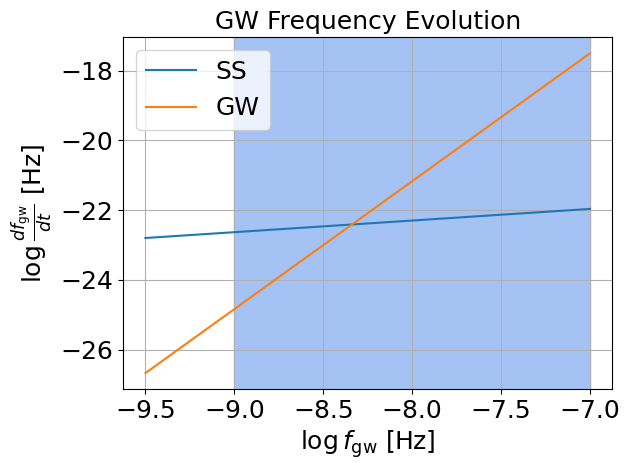

In [6]:
testM = 1e9 * u.solMass
testq = 1
testSigma = 100 * u.km / u.s
testRho = 1e12 * u.solMass / (u.kpc ** 3)

testChirp = testM * (testq / (1 + testq) ** 2) ** (3/5)

logFrequencies = np.linspace(-9.5, -7)

logSSEvolutions = []
for x in range(len(logFrequencies)):
    logSSEvolutions.append(np.log10(ssFrequencyDerivative(testM, testSigma, testRho, (10 ** logFrequencies[x]) * u.Hz) * u.s**2) )

#I think this is scaled wrong
logGWEvolutions = []
for x in range(len(logFrequencies)):
    logGWEvolutions.append(utils.logGWFrequencyDerivative(testChirp.value, 10 ** logFrequencies[x]))

plt.plot(logFrequencies, logSSEvolutions, label="SS")
plt.plot(logFrequencies, logGWEvolutions, label="GW")
#works totally fine, the issue is just plotting
plt.xlabel(r"$\log f_{\text{gw}}$ [Hz]", fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.axvspan(-9, -7, color="#a4c2f4ff")
plt.ylabel(r"$\log \frac{df_{\text{gw}}}{dt}$ [Hz]", fontsize = 18) #or should this be Hz^2?
plt.title("GW Frequency Evolution", fontsize = 18)
plt.legend(fontsize = 18)
plt.grid()
plt.tight_layout()
plt.savefig("example.png", transparent = True)

#LABEL AXES. WITH PROPER UNITS!!

#plt.vlines(-9.0, -34, -17) #an attempt to draw the 1-nHz boundary

#ssFrequencyDerivative(testM, testSigma, testRho, frequencies[-1])

The following code produces three color maps for the crossover point depending on how you vary $\rho$, $\sigma$, and $M$. It takes a while to calculate it all; this is a very high-density color map, and you're making three of them.

In [7]:
testSigma = 100

logMSamples = np.linspace(9, 6)
logRhoSamples = np.linspace(9, 17) #milky way seems to have about 10^9 solar masses per kpc so

noSigma = [0] * len(logMSamples)
for m in range(len(logMSamples)):
    noSigma[m] = []
    for r in range(len(logRhoSamples)):
        noSigma[m].append(findCrossoverBetweenSSandGW(10 ** logMSamples[m], testSigma, 10 ** logRhoSamples[r]))

In [8]:
testRho = 1e14
logMSamples = np.linspace(6, 9)
logSigmaSamples = np.linspace(3, 1)

noRho = [0] * len(logSigmaSamples)
for s in range(len(logSigmaSamples)):
    noRho[s] = []
    for m in range(len(logMSamples)):
        noRho[s].append(findCrossoverBetweenSSandGW(10 ** logMSamples[m], 10 ** logSigmaSamples[s], testRho))

In [9]:
testM = 1e8

logRhoSamples = np.linspace(9, 17)
logSigmaSamples = np.linspace(3, 1)

noM = [0] * len(logSigmaSamples)
for s in range(len(logSigmaSamples)):
    noM[s] = []
    for r in range(len(logRhoSamples)):
        noM[s].append(findCrossoverBetweenSSandGW(testM, 10 ** logSigmaSamples[s], 10 ** logRhoSamples[r]))

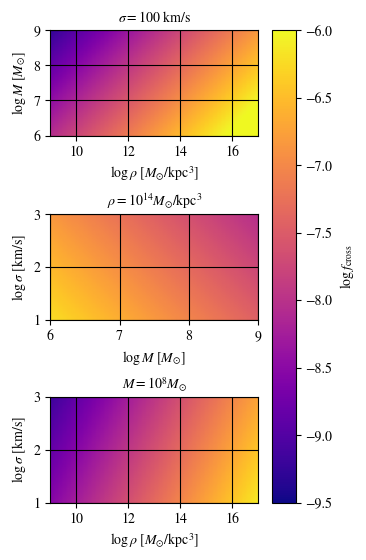

In [10]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

fig, ax = plt.subplots(3, 1, figsize=figsize3(0.5), layout="constrained")

# Plot data
mapped = ax[0].imshow(noSigma, extent=[9, 17, 6, 9], vmin = -9.5, vmax =-6, cmap="plasma", aspect='auto')
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[0].set_ylabel(r"$\log M\ [M_{\odot}]$", fontsize = 10)
ax[0].set_xlabel(r"$\log \rho \ [M_{\odot} / \text{kpc}^3]$", fontsize = 10)
ax[0].set_title(r"$\sigma = 100$ km/s", fontsize = 10)
ax[0].grid(color="black")

secondMapped = ax[1].imshow(noRho, extent=[6, 9, 1, 3],  vmin = -9.5, vmax =-6, cmap="plasma", aspect='auto')
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].set_ylabel(r"$\log \sigma$ [km/s]", fontsize = 10)
ax[1].set_xlabel(r"$\log M\ [M_{\odot}]$", fontsize = 10)
ax[1].set_title(r"$\rho = 10^{14} M_{\odot}/\text{kpc}^3$", fontsize = 10)
ax[1].grid(color="black")

ax[2].imshow(noM, extent=[9, 17, 1, 3],  vmin = -9.5, vmax =-6, cmap="plasma", aspect='auto')
ax[2].tick_params(axis='both', which='major', labelsize=10)
ax[2].set_ylabel(r"$\log \sigma$ [km/s]", fontsize = 10)
ax[2].set_xlabel(r"$\log \rho\ [M_{\odot} / \text{kpc}^3]$", fontsize = 10)
ax[2].set_title(r"$M = 10^8 M_{\odot}$", fontsize = 10)
ax[2].grid(color="black")

fig.colorbar(secondMapped, ax=ax, location="right", label=r"$\log f_{\text{cross}}$")

fig.savefig("crossover.png")

Below is the code to produce two graphs of change in frequency varied by pulsar distance and whether GW or SS dominates and whether it's detectable. These are vertical graphs, not using Sarah's figsize function. These are obsolete and not used in the paper, or even the presentation. But. I liked them.

In [11]:
def whatColorVertical(mass, f, graphTime):
    #graphTime in years
    graphSigma = 100 * u.km / u.s
    graphRho = 1e14 * u.solMass / (u.kpc ** 3)
    chirp = mass * (testq / (1 + testq) ** 2) ** (3/5)
    
    gw = utils.gwFrequencyChangeApprox(chirp, f, graphTime)
    ss = ssFrequencyChange(mass * u.solMass, f * u.Hz, graphSigma, graphRho, graphTime)
    ss = ss.value
    
    if(gw > ss):
        if(gw+ss > 1e-10):
            return 0.25
        else:
            return 0
    elif((ss+gw) < 1e-10):
        return 0.75
    else:
        return 0.5
    
logGridMasses = np.linspace(10, 6, 200)
logGridFrequencies = np.linspace(-9, -7, 100)
        
def evolveVertical(distance):
    #distance in kpc
    time = distance * const.kpc / const.c / const.yr
    evolutionValues = [0] * len(logGridMasses)
    for m in range(len(logGridMasses)):
        evolutionValues[m] = []
        for f in range(len(logGridFrequencies)):
            evolutionValues[m].append(whatColorVertical(10 ** logGridMasses[m], 10 ** logGridFrequencies[f], time))
    return evolutionValues

evolutionsOne = evolveVertical(1)
evolutionsTen = evolveVertical(10)
evolutionsLMC = evolveVertical(48500)

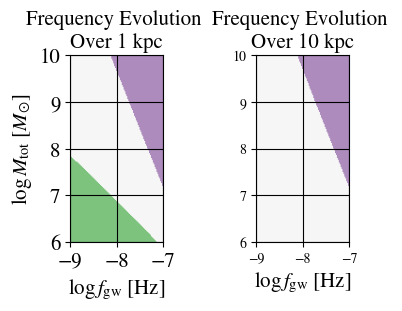

In [12]:
# Create a grid of 2 rows and 3 columns, and use gridspec to span subplots
fig, axs = plt.subplots(1, 2, layout="constrained", figsize = (4, 3))

# Plot data
axs[0].imshow(evolutionsOne, extent=[-9, -7, 6, 10], cmap="PRGn", vmin=0, vmax=1)
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].set_xlabel(r"$\log f_{\text{gw}}$ [Hz]", fontsize = 15)
axs[0].set_ylabel(r"$\log M_{\text{tot}}\ [M_{\odot}$]", fontsize = 15)
axs[0].set_title("Frequency Evolution \nOver 1 kpc", fontsize = 15)
axs[0].grid(color="black")

axs[1].imshow(evolutionsTen, extent=[-9, -7, 6, 10], cmap="PRGn", vmin=0, vmax=1)
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[1].set_xlabel(r"$\log f_{\text{gw}}$ [Hz]", fontsize = 15)
axs[0].set_ylabel(r"$\log M_{\text{tot}}\ [M_{\odot}$]", fontsize = 15)
axs[1].set_title("Frequency Evolution \nOver 10 kpc", fontsize = 15)
axs[1].grid(color="black")

#plt.savefig("labels.png", transparent=True)
plt.show()

Below is the code to produce two graphs of change in frequency varied by pulsar distance and whether GW or SS dominates and whether it's detectable. These are horizontal graphs, and golden ratio graphs sized using Sarah's figsize functions. These *were* used in the paper. The cutoff for detection is 1nHz, which is a little questionable.

In [13]:
#graphs varied by distance
def whatColor(mass, f, graphTime):
    #graphTime in years
    graphSigma = 1000 * u.km / u.s
    graphRho = 1e15 * u.solMass / (u.kpc ** 3)
    chirp = mass * (testq / (1 + testq) ** 2) ** (3/5)
    
    gw = utils.gwFrequencyChangeApprox(chirp, f, graphTime)
    ss = ssFrequencyChange(mass * u.solMass, f * u.Hz, graphSigma, graphRho, graphTime)
    ss = ss.value
    
    if(gw > ss):
        if(gw+ss > 1e-10):
            return 0.25
        else:
            return 0
    elif((ss+gw) < 1e-10):
        return 0.75
    else:
        return 0.5
    
logGridMasses = np.linspace(6, 10, 200)
logGridFrequencies = np.linspace(-7, -9, 100)
        
def evolve(distance):
    #distance in kpc
    time = distance * const.kpc / const.c / const.yr
    evolutionValues = [0] * len(logGridFrequencies)
    for f in range(len(logGridFrequencies)):
        evolutionValues[f] = []
        for m in range(len(logGridMasses)):
            evolutionValues[f].append(whatColor(10 ** logGridMasses[m], 10 ** logGridFrequencies[f], time))
    return evolutionValues

evolveOne = evolve(1)
evolveTen = evolve(10)

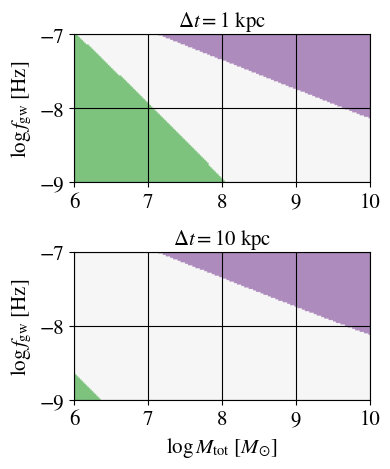

In [14]:
# Create a grid of 2 rows and 3 columns, and use gridspec to span subplots
#fig, axs = plt.subplots(1, 2, layout="constrained", figsize = (4, 3))
#fig, axs = plt.subplots(2, 1, layout="constrained") #wspace?
fig, axs = plt.subplots(2, 1)

# Plot data
axs[0].imshow(evolveOne, extent=[6, 10, -9, -7], cmap="PRGn", vmin=0, vmax=1)
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].set_ylabel(r"$\log f_{\text{gw}}$ [Hz]", fontsize = 15)
axs[0].set_title(r"$\Delta t = 1$ kpc", fontsize = 15)
axs[0].grid(color="black")

axs[1].imshow(evolveTen, extent=[6, 10, -9, -7], cmap="PRGn", vmin=0, vmax=1)
axs[1].tick_params(axis='both', which='major', labelsize=15)
axs[1].set_xlabel(r"$\log M_{\text{tot}}\ [M_{\odot}$]", fontsize = 15)
axs[1].set_ylabel(r"$\log f_{\text{gw}}$ [Hz]", fontsize = 15)
axs[1].set_title(r"$\Delta t = 10$ kpc", fontsize = 15)
axs[1].grid(color="black")

"""norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="PRGn"),
             ax=axs[:4], orientation='horizontal', 
             label=r'GW > SS   Not Detectable   SS > GW, Detectable')"""

plt.tight_layout()
plt.savefig("frequencyEvolutionByDistance.png")
plt.show()

Below is the code to produce four graphs of change in frequency varied by environmental variables ($\rho$ and $\sigma$) and whether GW or SS dominates and whether it's detectable. Used in the paper. 1nHz is the cutoff for being detectable, which is a little questionable.

In [15]:
#graphs varied by source parameters--the data
def correctColor(mass, f, graphTime, sigma, rho):
    #graphTime in years
    graphSigma = sigma * u.km / u.s
    graphRho = rho * u.solMass / (u.kpc ** 3)
    chirp = mass * (testq / (1 + testq) ** 2) ** (3/5)
    
    gw = utils.gwFrequencyChangeApprox(chirp, f, graphTime)
    ss = ssFrequencyChange(mass * u.solMass, f * u.Hz, graphSigma, graphRho, graphTime)
    ss = ss.value
    
    if(gw > ss):
        if(gw+ss > 1e-10):
            return 0.25
        else:
            return 0
    elif((ss+gw) < 1e-10):
        return 0.75
    else:
        return 0.5
    
logGridMasses = np.linspace(6, 10, 200)
logGridFrequencies = np.linspace(-7, -9, 100)
        
def evolve1(sigma, rho):
    #distance in kpc
    time = const.kpc / const.c / const.yr
    evolutionValues = [0] * len(logGridFrequencies)
    for f in range(len(logGridFrequencies)):
        evolutionValues[f] = []
        for m in range(len(logGridMasses)):
            evolutionValues[f].append(correctColor(10 ** logGridMasses[m], 10 ** logGridFrequencies[f], time, sigma, rho))
    return evolutionValues

topLeft = evolve1(100, 1e12)
topRight = evolve1(1000, 1e12)
botLeft = evolve1(100, 1e15)
botRight = evolve1(1000, 1e15)

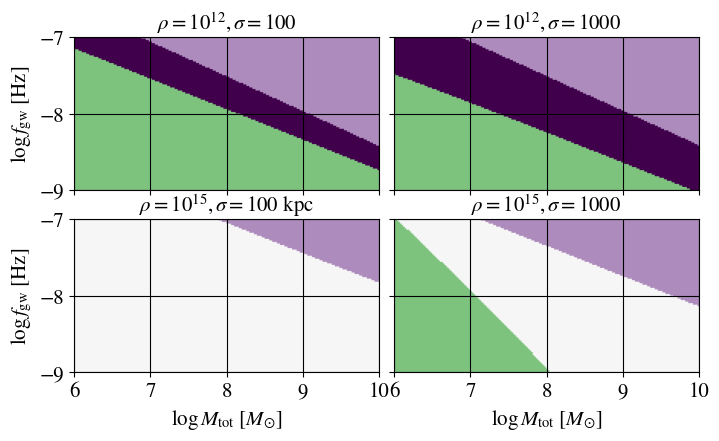

In [16]:
#graphs varied by source parameters--the graphs
fig = plt.figure()
subfigs = fig.subfigures(1, 2) #wspace? doesn't help vertical spacing, just gives me unnecessary horizontal spacing

#top left
axTopLeft = subfigs[0].subplots(2, 1, sharex = True)

axTopLeft[0].imshow(topLeft, extent=[6, 10, -9, -7], cmap="PRGn", vmin=0, vmax=1)
axTopLeft[0].tick_params(axis='both', which='major', labelsize=15)
axTopLeft[0].set_ylabel(r"$\log f_{\text{gw}}$ [Hz]", fontsize = 15)
axTopLeft[0].set_title(r"$\rho = 10^{12}, \sigma = 100$", fontsize = 15)
axTopLeft[0].grid(color="black")

axTopLeft[1].imshow(botLeft, extent=[6, 10, -9, -7], cmap="PRGn", vmin=0, vmax=1)
axTopLeft[1].tick_params(axis='both', which='major', labelsize=15)
axTopLeft[1].set_xlabel(r"$\log M_{\text{tot}}\ [M_{\odot}$]", fontsize = 15)
axTopLeft[1].set_ylabel(r"$\log f_{\text{gw}}$ [Hz]", fontsize = 15)
axTopLeft[1].set_title(r"$\rho = 10^{15}, \sigma = 100$ kpc", fontsize = 15)
axTopLeft[1].grid(color="black")

#top right
axTopRight = subfigs[1].subplots(2, 1, sharex = True)

axTopRight[0].imshow(topRight, extent=[6, 10, -9, -7], cmap="PRGn", vmin=0, vmax=1)
axTopRight[0].tick_params(axis='both', which='major', labelsize=15)
axTopRight[0].set_yticklabels([])
axTopRight[0].set_title(r"$\rho = 10^{12}, \sigma = 1000$", fontsize = 15)
axTopRight[0].grid(color="black")

axTopRight[1].imshow(botRight, extent=[6, 10, -9, -7], cmap="PRGn", vmin=0, vmax=1)
axTopRight[1].tick_params(axis='both', which='major', labelsize=15)
axTopRight[1].set_xlabel(r"$\log M_{\text{tot}}\ [M_{\odot}$]", fontsize = 15)
axTopRight[1].set_yticklabels([])
axTopRight[1].set_title(r"$\rho = 10^{15}, \sigma = 1000$", fontsize = 15)
axTopRight[1].grid(color="black")

#still need to do bottom right, fix layout, and actually fill in the data

plt.tight_layout()
plt.savefig("sourceEvolution.png", bbox_inches='tight')

plt.show()

# Defunct functions

In [ ]:
def getHDefunct(separation, Mtot, sigma):
    """ 
    all variables in seconds
    """

    ah = getah(Mtot, 1, sigma)
    a = separation/ah   # define x to be orbital separation in units of ah
    
    A = 14.55
    a0 = 3.48
    gamma = -0.95
    
    return A*(1+a/a0)**gamma

^ as in Sesana (2006), where $H = A\left(1 + \frac{a}{a_0}\right)^{\gamma}$

In [ ]:
#there was a getah but I accidentally deleted it. yay!

In [ ]:
def getHFromFreq(f, M, sigma, rho):    
    #find separation (aka a) in terms of current parameters
    a = (M / np.pi**2 / f**2) ** (1/3)
    return getH(a, M, sigma)

In [ ]:
"""def ssFrequencyEvolution(M, f, sigma, rho):
    # f is GW frequency in Hz
    # M is total mass in solar masses
    # sigma in km/s
    # rho in solar masses/pc^3 I guess
    #returns the log of the evolution rate
    
    #set everything to seconds
    M *= const.Tsun # find mass expressed in seconds, rather than solar masses
    sigma = sigma * 1000 / const.c #I THINK. if c=1, that means speeds are generally unitless and expressed as percentage of c?
    rho = rho * const.Msun * const.pc**3 * const.G #I THINK. this gives units of s^-2, not sure if that's right
    
    #find separation (aka a) in terms of current parameters
    a = (M / np.pi**2 / f**2) ** (1/3)
    H = getH(a, M, sigma)
    
    evolutionRate = 3 * (2*np.pi)**(5/6) * rho * H * M**(1/3) * f**(1/3) / 2 / sigma
    return np.log10(evolutionRate)"""

def ssFrequencyEvolution(mass, sigma, rho, f, q=1):
    #derive separation from frequency
    separation = (G * mass / (np.pi * f) ** 2) ** (1/3)
    separation = separation.to(u.m)

    #code up H
    M2 = q * mass / (1 + q)
    ah = G * M2 / 4 / (sigma ** 2)
    ah = ah.to(u.m)
    a = separation/ah   # define a to be orbital separation in units of ah

    A = 14.55
    a0 = 3.48
    gamma = -0.95

    H = A*( 1 + (a/a0) ) ** gamma

    dfdt = 3 * (2 * np.pi) ** (5/6) * G ** (4/3) * rho * H * mass ** (1/3) * f ** (1/3) / 2 / sigma
    return dfdt.to(u.s ** -2)